In [1]:
import pandas as pd

# Upload local CSV file (for Colab environment)
from google.colab import files
uploaded = files.upload()

Saving Sample - Superstore.csv to Sample - Superstore.csv


In [2]:
# List uploaded files
import os
print("Uploaded files:", os.listdir())

Uploaded files: ['.config', 'Sample - Superstore.csv', 'sample_data']


In [3]:
# Read the dataset (Superstore sample)
df = pd.read_csv("Sample - Superstore.csv", encoding="ISO-8859-1")
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,10/11/2015,10/18/2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [4]:
# Basic descriptive statistics for numerical columns
df.describe()

,Row ID,Postal Code,Sales,Quantity,Discount,Profit
count,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000,9994.000000
mean,4997.500000,55190.379428,229.858001,3.789574,0.156203,28.656896
std,2885.163629,32063.693350,623.245101,2.225110,0.206452,234.260108
min,1.000000,1040.000000,0.444000,1.000000,0.000000,-6599.978000
25%,2499.250000,23223.000000,17.280000,2.000000,0.000000,1.728750
50%,4997.500000,56430.500000,54.490000,3.000000,0.200000,8.666500
75%,7495.750000,90008.000000,209.940000,5.000000,0.200000,29.364000
max,9994.000000,99301.000000,22638.480000,14.000000,0.800000,8399.976000


In [5]:
# Calculate quartiles for the 'Sales' column
q1 = df['Sales'].quantile(0.25)
q2 = df['Sales'].quantile(0.50)  # Median
q3 = df['Sales'].quantile(0.75)

print("Q1 (25th percentile):", q1)
print("Q2 (Median):", q2)
print("Q3 (75th percentile):", q3)

Q1 (25th percentile): 17.28
Q2 (Median): 54.489999999999995
Q3 (75th percentile): 209.94


In [7]:
# Compute IQR (Interquartile Range)
iqr = q3 - q1

# Define thresholds for outlier detection
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Identify outliers (sales above upper bound)
outliers = df[df['Sales'] > upper_bound]
print("Number of high outliers in Sales:", len(outliers))

# Preview some of the outlier records
outliers[['Product Name', 'Sales']].head()

Number of high outliers in Sales: 1167


,Product Name,Sales
1,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
3,Bretford CR4500 Series Slim Rectangular Table,957.5775
7,Mitel 5320 IP Phone VoIP phone,907.1520
10,Chromcraft Rectangular Conference Tables,1706.1840
11,Konftel 250 Conference phone - Charcoal black,911.4240


In [8]:
# Count how often each category appears among the sales outliers
outliers['Category'].value_counts()

,count
Category,
Furniture,467
Technology,400
Office Supplies,300


In [10]:
# Summary statistics for profit among outliers
outliers['Profit'].describe()

,Profit
count,1167.000000
mean,160.708308
std,657.523657
min,-6599.978000
25%,10.075550
50%,119.686000
75%,270.363600
max,8399.976000


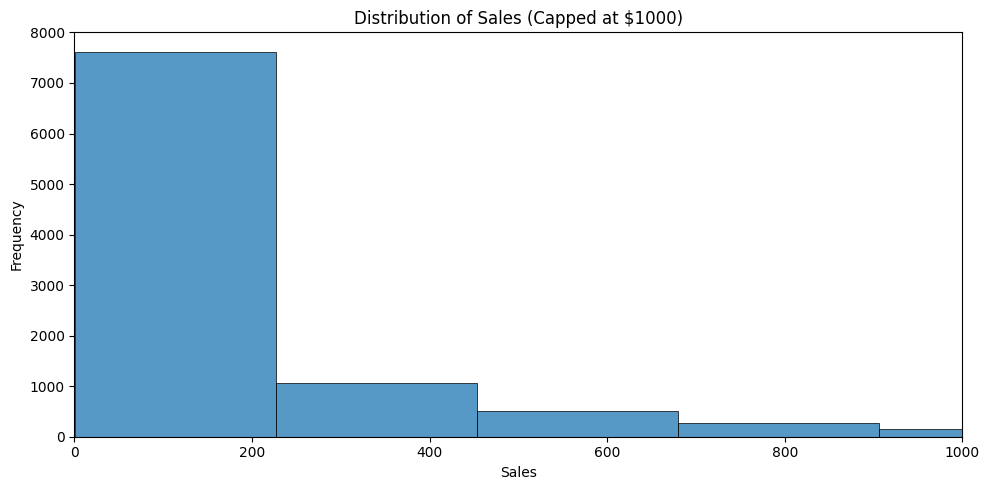

In [15]:
# Visualization: Distribution of Sales values
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(df['Sales'], bins=100)

# Limit the x-axis to exclude extreme outliers from skewing the plot
plt.xlim(0, 1000)
plt.title("Distribution of Sales (Capped at $1000)")
plt.xlabel("Sales")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [16]:
# Convert 'Order Date' column to datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Define a snapshot date (1 day after the last purchase in the dataset)
snapshot_date = df['Order Date'].max() + pd.Timedelta(days=1)

# Aggregate RFM metrics per customer
rfm = df.groupby('Customer ID').agg({
    'Order Date': lambda x: (snapshot_date - x.max()).days,  # Recency: days since last purchase
    'Order ID': 'nunique',                                   # Frequency: number of orders
    'Sales': 'sum'                                           # Monetary: total sales
}).reset_index()

# Rename columns
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()

,CustomerID,Recency,Frequency,Monetary
0,AA-10315,185,5,5563.560
1,AA-10375,20,9,1056.390
2,AA-10480,260,4,1790.512
3,AA-10645,56,6,5086.935
4,AB-10015,416,3,886.156


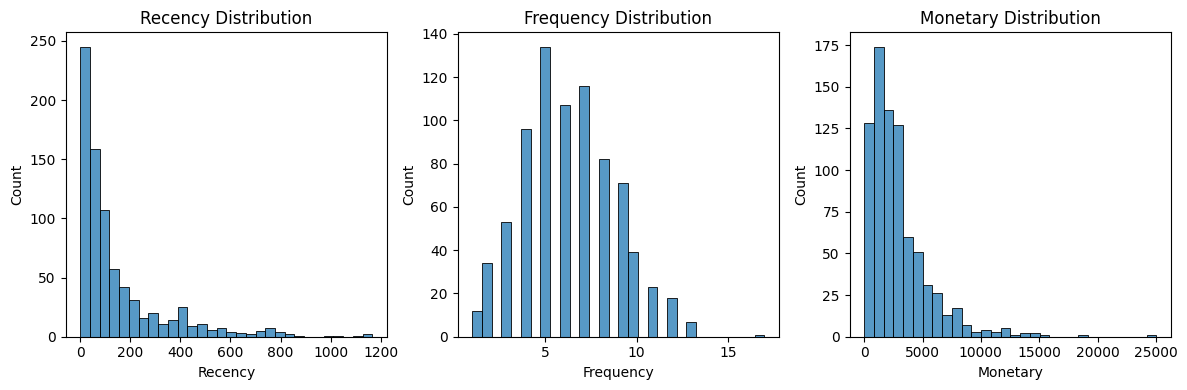

In [17]:
# Plot the distributions of RFM features
plt.figure(figsize=(12, 4))

# Recency Distribution
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], bins=30)
plt.title("Recency Distribution")

# Frequency Distribution
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], bins=30)
plt.title("Frequency Distribution")

# Monetary Distribution
plt.subplot(1, 3, 3)
sns.histplot(rfm['Monetary'], bins=30)
plt.title("Monetary Distribution")

plt.tight_layout()
plt.show()


In [18]:
# Assign R, F, M ranks using quartiles
# For Recency: lower is better, so reverse the labels
rfm['R_rank'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])

# For Frequency: higher is better, use ranking to break ties
rfm['F_rank'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])

# For Monetary: higher is better
rfm['M_rank'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Combine ranks into a single RFM score string
rfm['RFM_Score'] = (
    rfm['R_rank'].astype(str) +
    rfm['F_rank'].astype(str) +
    rfm['M_rank'].astype(str)
)

# Preview the RFM table with scores
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,RFM_Score
0,AA-10315,185,5,5563.560,1,1,4,114
1,AA-10375,20,9,1056.390,4,4,1,441
2,AA-10480,260,4,1790.512,1,1,2,112
3,AA-10645,56,6,5086.935,3,2,4,324
4,AB-10015,416,3,886.156,1,1,1,111


In [19]:
# Identify VIP customers (perfect score: 444)
vip = rfm[rfm['RFM_Score'] == '444']
vip.head()

,CustomerID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,RFM_Score
31,AH-10210,7,9,4805.344,4,4,4,444
35,AI-10855,14,10,4375.786,4,4,4,444
59,AT-10735,14,10,3831.864,4,4,4,444
65,BB-11545,29,9,6765.728,4,4,4,444
82,BF-11170,17,11,5907.972,4,4,4,444


<ipython-input-20-6c569f6458e8>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rfm_count = rfm.groupby(['R_rank', 'F_rank'])['CustomerID'].count().reset_index()


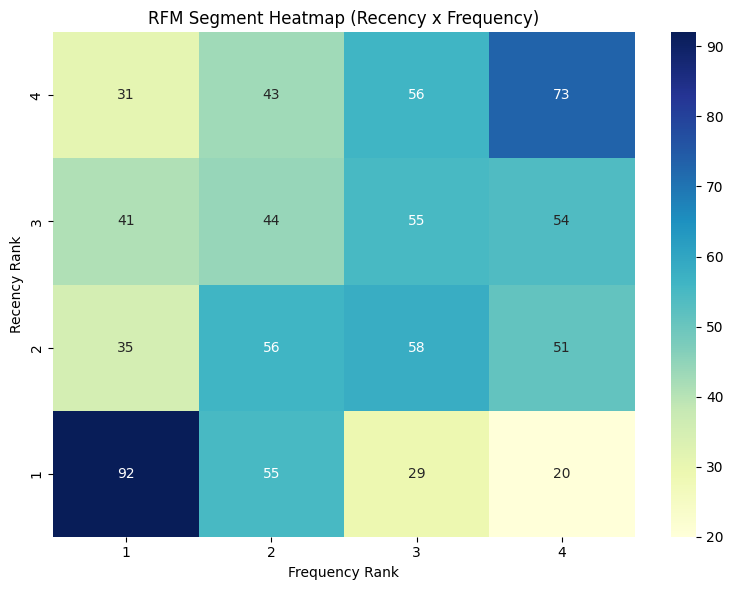

In [20]:
# Count number of customers for each Recency x Frequency combination
rfm_count = rfm.groupby(['R_rank', 'F_rank'])['CustomerID'].count().reset_index()

# Pivot for heatmap
rfm_count = rfm_count.pivot(index='R_rank', columns='F_rank', values='CustomerID')

# Plot heatmap of customer segments
plt.figure(figsize=(8, 6))
sns.heatmap(rfm_count, annot=True, fmt='d', cmap='YlGnBu')
plt.title("RFM Segment Heatmap (Recency x Frequency)")
plt.xlabel("Frequency Rank")
plt.ylabel("Recency Rank")
plt.tight_layout()
plt.show()

In [21]:
# Select customers whose Recency rank is 1 (i.e., haven't purchased in a long time)
low_value = rfm[rfm['R_rank'] == 1]

# Alternative: Select customers with the worst overall RFM score (111)
# low_value = rfm[rfm['RFM_Score'] == '111']

# Preview the least valuable customers based on monetary value
low_value.sort_values(by='Monetary').head()

,CustomerID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,RFM_Score
760,TS-21085,358,2,4.833,1,1,1,111
456,LD-16855,553,1,5.304,1,1,1,111
145,CJ-11875,366,1,16.520,1,1,1,111
508,MG-18205,265,1,16.739,1,1,1,111
690,SG-20890,227,3,47.946,1,1,1,111


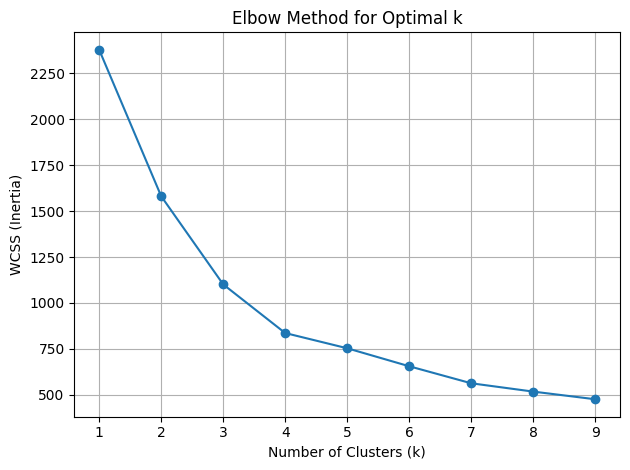

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Select numerical RFM features for clustering
rfm_for_model = rfm[['Recency', 'Frequency', 'Monetary']]

# Standardize features (important for distance-based models)
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_model)

# Elbow Method: compute Within-Cluster Sum of Squares (WCSS) for k = 1 to 9
wcss = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.plot(range(1, 10), wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.tight_layout()
plt.show()

✅ Apply KMeans with k=4 and Analyze Customer Segments

In [23]:
# Train KMeans with 4 clusters and assign cluster labels
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Preview with cluster assignments
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_rank,F_rank,M_rank,RFM_Score,Cluster
0,AA-10315,185,5,5563.560,1,1,4,114,1
1,AA-10375,20,9,1056.390,4,4,1,441,0
2,AA-10480,260,4,1790.512,1,1,2,112,1
3,AA-10645,56,6,5086.935,3,2,4,324,0
4,AB-10015,416,3,886.156,1,1,1,111,3


✅ Visualize Clusters (Recency vs Monetary)

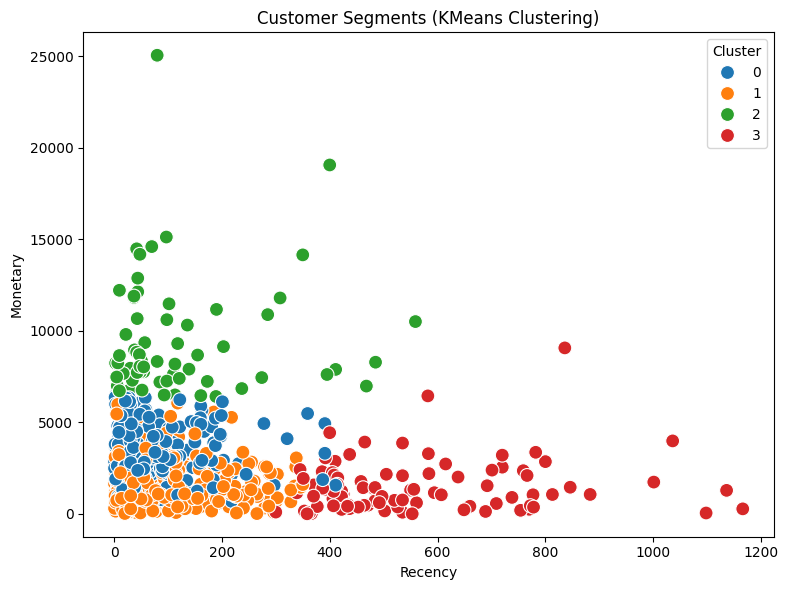

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Monetary',
    hue='Cluster',
    palette='tab10',
    s=100
)
plt.title("Customer Segments (KMeans Clustering)")
plt.xlabel("Recency")
plt.ylabel("Monetary")
plt.tight_layout()
plt.show()

✅ Profile Clusters by RFM Averages

In [25]:
# Average RFM values per cluster (for interpretation)
rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)

,Recency,Frequency,Monetary
Cluster,,,
0,72.74,8.52,3322.22
1,101.20,4.73,1669.69
2,123.72,8.30,9479.55
3,559.49,3.70,1470.23


✅ Monthly Sales Trend Analysis

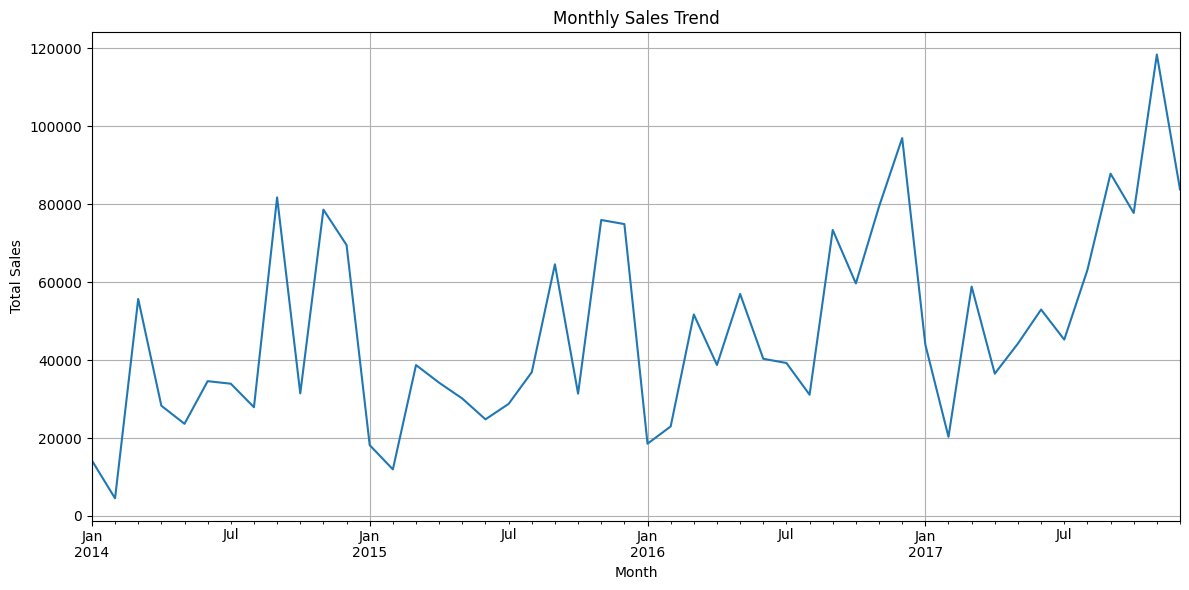

In [26]:
# Ensure 'Order Date' is in datetime format
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Extract Year-Month period from Order Date
df['Month'] = df['Order Date'].dt.to_period('M')

# Aggregate monthly sales
monthly_sales = df.groupby('Month')['Sales'].sum()

# Plot monthly sales trend
monthly_sales.plot(figsize=(12, 6), title='Monthly Sales Trend', xlabel='Month', ylabel='Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

✅ Sales by Region (Bar Chart)

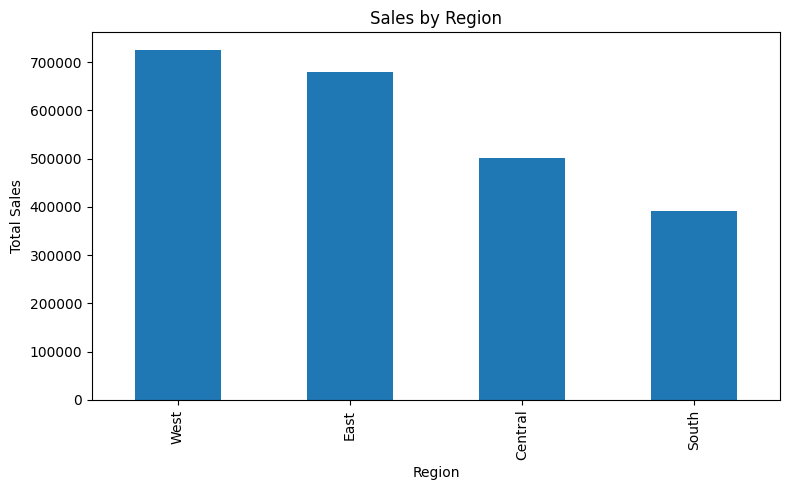

In [27]:
# Aggregate total sales by region
region_sales = df.groupby('Region')['Sales'].sum().sort_values(ascending=False)

# Plot sales by region
region_sales.plot(kind='bar', title='Sales by Region', figsize=(8, 5), ylabel='Total Sales', xlabel='Region')
plt.tight_layout()
plt.show()

✅ Build Random Forest Classifier to Predict Customer Segments

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Features (input variables)
X = rfm[['Recency', 'Frequency', 'Monetary']]

# Target (cluster labels from KMeans)
y = rfm['Cluster']

# Split into training and test sets (default 75% train, 25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Initialize and train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Predict cluster labels on test set
preds = model.predict(X_test)

# Evaluate model performance
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        64
           1       1.00      1.00      1.00        92
           2       0.90      1.00      0.95        19
           3       1.00      0.88      0.93        24

    accuracy                           0.98       199
   macro avg       0.97      0.97      0.97       199
weighted avg       0.99      0.98      0.98       199

